In [71]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
%matplotlib inline

from photutils import aperture_photometry as apPho, CircularAperture as cAp
from photutils import CircularAnnulus as cAn


In [72]:
# positions of stars on image
coord = [(102.64, 1003.96), (446.65, 994.0), 
         (202.79,622.62), (378.22, 861.50),
         (220.12, 541.22), (198.97, 404.96),
         (173.55, 25.93), (428.61, 137.90),
         (729.54, 75.78), (542.92, 99.42)]

data = fits.getdata('quadRU.fits')
apertures = cAp(coord, r=7)

In [77]:
center = apPho(data, apertures, method='center')
subpixel = apPho(data, apertures, method='subpixel')
exact = apPho(data, apertures)
print(center)

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1  102.64 1003.96 143711.02726956905
  2  446.65   994.0   265314.912424934
  3  202.79  622.62 248872.41405302568
  4  378.22   861.5  96882.40497271513
  5  220.12  541.22  140647.0084171276
  6  198.97  404.96  449187.6513376356
  7  173.55   25.93 129854.20921868144
  8  428.61   137.9   214557.655149301
  9  729.54   75.78 142017.79748544467
 10  542.92   99.42  295757.1893276102


In [75]:
annulus = cAn(coord, r_in=10., r_out=12.)
center_annulus = apPho(data, annulus, method='center')
print(center_annulus)

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1  102.64 1003.96  35758.81365677711
  2  446.65   994.0  41457.16477606955
  3  202.79  622.62  37466.93584485998
  4  378.22   861.5  36552.42389404331
  5  220.12  541.22  38133.06207942226
  6  198.97  404.96 39702.104654423565
  7  173.55   25.93  37343.11232776623
  8  428.61   137.9  39485.46767274711
  9  729.54   75.78 37815.103416549886
 10  542.92   99.42  41076.57281773512


In [152]:
bkg_mean = center_annulus['aperture_sum'] / annulus.area()
bkg_sum = bkg_mean * apertures.area()
final_sum = center['aperture_sum'] - bkg_sum
center['residual_aperture_sum'] = final_sum
print(bkg_sum)
print(center)

   aperture_sum   
------------------
32557.044540438703
 44639.29972126747
 39415.10461592498
 40134.36338808242
39706.587153497974
40597.181386832155
40221.226123323104
 41007.31125188911
40915.298684194226
41236.674065718005
 id xcenter ycenter    aperture_sum    residual_aperture_sum
      pix     pix                                           
--- ------- ------- ------------------ ---------------------
  1  102.64 1003.96   286203.827503961    253646.78296352227
  2  446.65   994.0  435056.6629357892     390417.3632145217
  3  202.79  622.62 403192.05974959856    363776.95513367356
  4  378.22   861.5 244459.26453068625    204324.90114260383
  5  220.12  541.22  291188.2417948419    251481.65464134392
  6  198.97  404.96  627095.7643066149     586498.5829197827
  7  173.55   25.93   279457.512569697    239236.28644637388
  8  428.61   137.9 373662.98204717075    332655.67079528165
  9  729.54   75.78 295486.24867597315    254570.94999177894
 10  542.92   99.42 461197.35334156215  

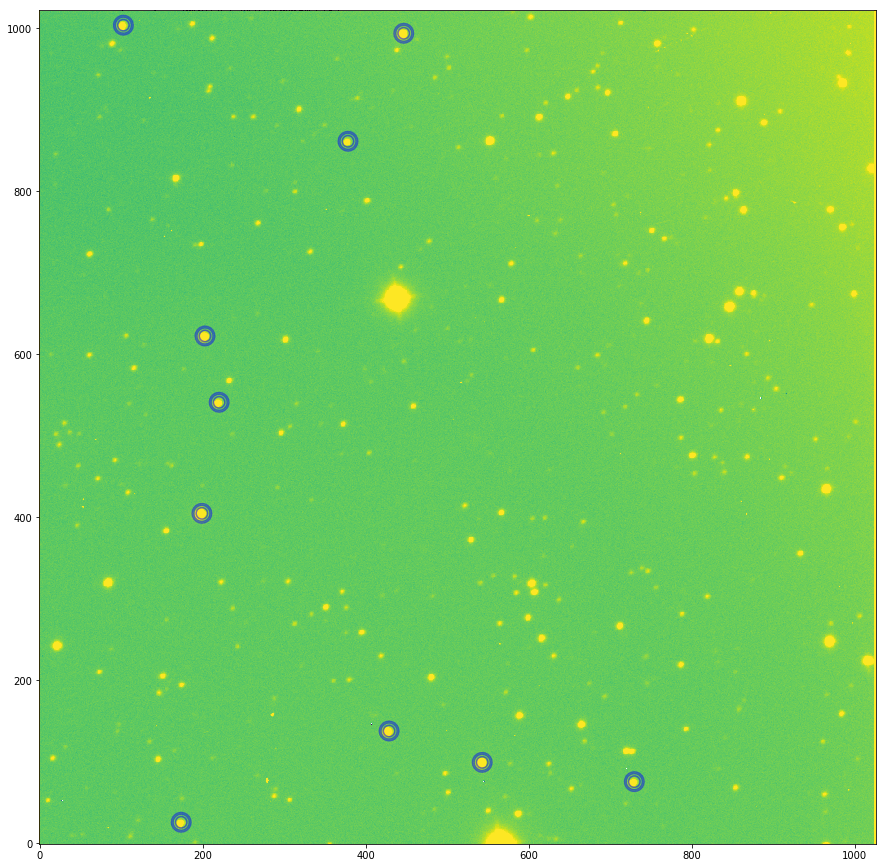

In [78]:
plt.figure(figsize=(15,20))
plt.imshow(data, norm=LogNorm(20, 600), origin='lower')

apertures.plot(color='blue', lw=1.5, alpha=0.5)
annulus.plot(color='blue', lw=1.5, alpha=0.5)

In [86]:
avg_count = []
methods = ['center', 'subpixel']
radii = np.linspace(5,15, 10)
for i in methods:
    avg_count_radii = []
    for j in radii:
        aperture = cAp(coord, r=j)
        annulus = cAn(coord, r_in=(j+3), r_out=(j+6))
        
        center = apPho(data, aperture, method=i)
        center_annulus = apPho(data, annulus, method=i)
        
        bkg_mean = center_annulus['aperture_sum'] / annulus.area()
        bkg_sum = bkg_mean * aperture.area()
        final_sum = center['aperture_sum'] - bkg_sum
        center['residual_aperture_sum'] = final_sum
        
        avg_count_radii.append((final_sum / apertures.area())[3])
    avg_count.append(avg_count_radii)

[[322.19665114714746, 345.96537604311044, 354.2624582122487, 375.93893465805246, 362.67304471724236, 392.0229154596134, 370.85296461596835, 395.1271234961007, 382.37931587291746, 407.6808349812542], [322.07095150487925, 347.9791181646294, 362.4073168823803, 373.7743544956653, 380.1089249792667, 384.6505584936416, 385.01658069554196, 386.63295263987925, 389.17514132071614, 390.8638851814213]]


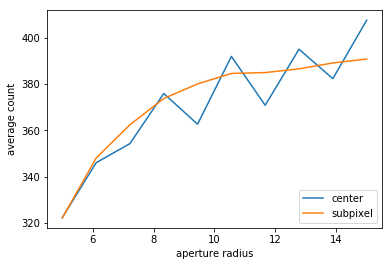

In [90]:
plt.plot(radii, avg_count[0], label='center')
plt.plot(radii, avg_count[1], label='subpixel')
plt.xlabel('aperture radius')
plt.ylabel('average count')
plt.legend(loc=4)

# PSF

In [95]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

In [99]:
sigma_psf = 2
bkgrms = MADStdBackgroundRMS()
std = bkgrms(data)
iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
from photutils.psf import IterativelySubtractedPSFPhotometry
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                group_maker=daogroup,
                                                bkg_estimator=mmm_bkg,
                                                psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=1, fitshape=(11,11))
result_tab = photometry(image=data)
residual_image = photometry.get_residual_image()

In [105]:
photometry = BasicPSFPhotometry(group_maker=daogroup,
                                bkg_estimator=mmm_bkg,
                                psf_model=psf_model,
                                fitter=LevMarLSQFitter(),
                                fitshape=(11,11))
pos = Table(names=['x_0', 'y_0'], data=[center['xcenter'],
                                        center['ycenter']])
result_tab = photometry(image=data, init_guesses=pos)
residual_image = photometry.get_residual_image()
result_tab

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,x_0_unc,y_0_unc
pix,pix,,,,,,,,,
float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
102.64,1003.96,91101.0050773564,1,1,101.85096555793152,1003.0762790980253,105332.23960560194,1138.9171912726365,0.031054545582487998,0.030997107650055682
446.65,994.0,194487.79228436254,2,2,445.5244374416297,993.2114265854567,226000.40019697705,2361.739013763001,0.030136007310689206,0.029936653276004085
202.79,622.62,178836.62051203064,3,3,201.66920313882892,621.6705532884248,207347.2628588645,2051.6719542723627,0.028482572669159715,0.028474470383318663
378.22,861.5,49067.233608593444,4,4,377.4514793473917,860.5596116679452,56165.07188507577,569.4179548022581,0.029014248335684948,0.029215556872493678
220.12,541.22,85957.11958830548,5,5,218.92155714233385,540.1988391766838,100065.15035878657,947.8013100078397,0.027187495911248055,0.027135346093547216
198.97,404.96,354262.47083822056,6,6,197.72009192596138,404.2043537721899,408361.12540431524,3718.8481314101678,0.026196836076490683,0.026089194899836337
173.55,25.93,77439.39109756003,7,7,172.86970049979024,24.82653060491785,87970.33569649418,832.1267275742779,0.027166235783420565,0.027181006020389763
428.61,137.9,145331.83858891402,8,8,427.1724367511522,136.89046598754214,170191.9609923735,1565.0583104466684,0.026731862307774277,0.026405156464592686


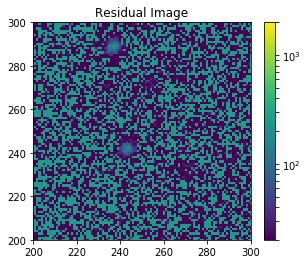

In [146]:
plt.imshow(data, cmap='viridis', interpolation='nearest', origin='lower', 
           norm=LogNorm(20,2000));
plt.imshow(residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower', norm=LogNorm(20,2000));
plt.xlim(200, 300);
plt.ylim(200, 300);
plt.title('Residual Image');
plt.colorbar(fraction=0.046, pad=0.04);

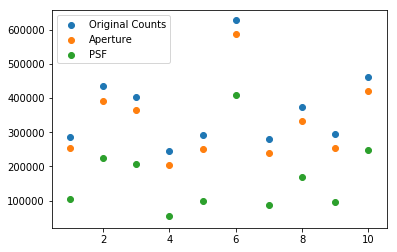

In [151]:
fig, ax = plt.subplots()
ax.scatter(center["id"], center["aperture_sum"], label="Original Counts")
ax.scatter(center["id"], center["residual_aperture_sum"], label="Aperture")
ax.scatter(result_tab["id"], result_tab["flux_fit"], label="PSF")
plt.legend(loc=2)
plt.show()